# GPT Model from Scratch

This notebook implements a GPT-style Transformer model from the ground up.

- Reference: [Transformers from Scratch](https://e2eml.school/transformers.html) — a clear and visual explanation of the architecture.
- Based on the video by Andrej Karpathy: [Let's Build GPT](https://youtu.be/kCc8FmEb1nY?si=LlLJEVIP3E9ltZ4X)

Thanks to [Luckyluuuc/GPTmodel](https://github.com/Luckyluuuc/GPTmodel) for the original code base.


In [1]:
import torch

debug =  False
monitoring = False # set to true if you want to monitor during the training with the wandb librairie
word_level = True #if word level is set to True the model will predict word by word , else character by character
cfg = {
    'description' :"entrainement classique",
    'batch_size': 64,
    'block_size': 128,
    'max_iters': 3000,
    'eval_interval': 200,
    'learning_rate': 1e-4,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'eval_iters': 200,
    'n_embed': 256, #should be divisible by num_head
    'num_heads': 8,
    'num_blocks': 6,
    'dropout': 0.4,
    'fraction_training_data': 0.9,
    'word_level' : word_level
}

torch.manual_seed(1337)
print("GPU : ",  torch.cuda.is_available())


GPU :  True


In [2]:
# download libriairies, code and data that we need

if monitoring : # install the librairie wandb to monitor the loss etc..
  !pip install wandb

#install gradio
!pip install gradio
#my files with classes and functions
#Training corpus:
!wget https://raw.githubusercontent.com/Luckyluuuc/GPTmodel/main/data/harry-potter-7.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 133.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.4 MB/s eta 0:00:00
--2025-04-23 20:44:34--  https://raw.githubusercontent.com/Luckyluuuc/GPTmodel/main/data/harry-potter-7.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1453073 (1.4M) [text/plain]
Saving to: ‘harry-potter-7.txt’

harry-potter-7.txt  100%[===================>]   1.39M  --.-KB/s    in 0.01s

In [3]:
#import the librairies

#pytorch:
# torch already imported above
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim


#to monitor :
if monitoring : import wandb
from tqdm.auto import tqdm # for the progress bar
import matplotlib.pyplot as plt


# to have a nice interface to generate text
import gradio as gr

In [4]:
if monitoring: wandb.init(project='GPT Harry potter word level', config=cfg)

### Download and prepare the data


In [5]:
# @title Data utils
import torch
import re

#-----------------

def tokenize_text(text): #function to transform the text in a list of word when we want to train the model at word level
    # Use a regular expression to tokenize the text into words while preserving spaces and line breaks
    tokens =  re.findall(r'\w+|[\.,;!?"]+|\n|\t|.', text)
    return tokens
#-----------------
def mapp(text): # return 2 dictionnaries mapping each token to an integers and vice versa
  list_token = sorted(list(set(text)))
  vocab_size = len(list_token)
  stoi = {c:i for i,c in enumerate(list_token)}
  itos = {i:c for i,c in enumerate(list_token)}

  return vocab_size, stoi, itos
#-----------------

def splitting_data(frac, data): #split the data in validation_set and training_set
    z = int(frac*len(data))
    train_set = data[:z]
    validation_set = data[z:]
    return train_set, validation_set

#-----------------

def encode(text, stoi): #encode a list of token into a list of integers
  list_integers = []
  for c in text:
    list_integers.append(stoi.get(c, 2)) # if the word is not in the dictionary it encode it as a space

  return list_integers

#-----------------

def decode(list_integers, itos): #decode a list of integer into a string
  text = []
  for i in list_integers:
    text.append(itos.get(i))

  text = ''.join(c for c in text) #delete this line if you want a list of token instead of a str
  return text

#-----------------

def get_batch(split, block_size, batch_size, device, train_set, validation_set): #split is either "train" or "eval"
  assert split in ["train", "eval"], "split must be 'train' or 'eval'"
  data = train_set if split == "train" else validation_set

  ix = torch.randint(0, len(data) - block_size-1, (batch_size,)) # return a tensor of shape (batch_size) with random values between 0 and len(data) - block_size

  x = torch.stack([torch.tensor(data[i:i + block_size]) for i in ix])
  y = torch.stack([torch.tensor(data[i + 1:i + block_size + 1]) for i in ix])

  x, y = x.to(device), y.to(device)
  return x, y
#-----------------
#objective : calculate the training/validation loss on several iters ("eval_iters" iterations)
@torch.no_grad() #we don't want to calculate any gradient with this function
def estimate_loss(m, eval_iters, train_set, evalutation_set, block_size, batch_size, device):
  out = {}
  m.eval() # to desactivate layer that are relevant in training only, e.g. dropout
  for split in ["train", "eval"]: # we calculate the loss on both the training set and validation set
    losses = torch.zeros(eval_iters)
    for k in range(eval_iters):
      X, Y = get_batch(split, block_size, batch_size, device, train_set, evalutation_set)
      logits, loss = m(X, Y)
      losses[k] = loss.item()
    out[split] = losses.mean()
  m.train()
  return out
#-----------------

class WeightManager: #class to manage the savings of the weigths
    def __init__(self, file_path):
        self.file_path = file_path

    def save_weights(self, model):
        torch.save(model.state_dict(), self.file_path)

    def load_weights(self, model):
        model.load_state_dict(torch.load(self.file_path))
        model.eval()  # Set the model to evaluation mode

In [6]:
with open('/content/harry-potter-7.txt', 'r', encoding='utf-8') as f: # choose the training corpus here
    text = f.read()
print("length of dataset in characters: ", len(text))
if len(text) < 1000000 : print("the length of the corpus is less than 1M characters it might be to small")
print( "\n\n An extract of the data : \n\n\n " ,"\033[31m", text[1000:2000])

if word_level :
  text = tokenize_text(text)

print('\033[0m', "\n\n\n", "An extract of 20 tokens",list(text[1000:1020]))

length of dataset in characters:  1346804


 An extract of the data : 


    ? demanda le plus grand des deux.

— Excellentes, répondit Severus Rogue.

Le chemin était bordé à gauche par des mûriers sauvages aux tiges basses et, à droite, par une haute
haie soigneusement taillée. Les longues capes des deux hommes ondulaient autour de leurs chevilles
au rythme de leurs pas.

— J’ai cru que j’allais arriver en retard, dit Yaxley, dont le visage taillé à coups de serpe apparaissait
et disparaissait sous les branches des arbres qui masquaient par endroits la lueur de la lune. C’était un
peu plus difficile que je ne l’avais pensé. Mais j’espère qu’il sera satisfait. Tu as l’air sûr de toi. Tu
penses que tu seras bien reçu ?

Rogue acquiesça d’un signe de tête mais ne donna pas de détails. Ils tournèrent à droite, dans une
large allée qui s’éloignait du chemin. La haute haie suivit la même courbe, s’étendant au loin, par-
delà l’impressionnant portail de fer forgé qui barrait la route des de

### Create a map between characters and integers
**Objective**: associate to each characters to an integers using dictionnaries

In [7]:
vocab_size, stoi, itos = mapp(text) #we assign to each token an integers and itos and stoi are the dictionnaries that allow to pass from one to the other and vice versa
data_tok = encode(text, stoi) # we tranform our text into a list of integers thanks to the dictionnary stoi

if debug:
  print("vocab_size :", vocab_size)
  print("stoi :", stoi)
  print("itos :", itos)
  print("First 100 token of the encoded text : ", data_tok[:100])

#splitting the data -> one for training and one for evaluating (cross_validation)

train_set, validation_set = splitting_data(cfg.get('fraction_training_data'), data_tok)

if debug:
  print("")
  print("train set -> length :", len(train_set))
  print(train_set[:50])
  print("validation set -> length :", len(validation_set))
  print(validation_set[:50])





# GPT Model

## Multi-Head Self-Attention



### Head

A single self-attention head:
- Projects input into queries (Q), keys (K), and values (V)
- Computes scaled dot-product attention with causal masking
- Applies dropout to attention weights

**Formulas**:

- Projections:  
  $$
  Q = XW^Q,\quad K = XW^K,\quad V = XW^V
  $$

- Attention scores (scaled dot-product):  
  $$
  A = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
  $$

- Output:  
  $$
  \text{Attention}(Q, K, V) = A \cdot V
  $$

### MultiHeadAttention

- Applies multiple heads in parallel
- Concatenates their outputs
- Applies a final linear projection

**Formula**:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O
$$

Where each head is computed as:  
$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

In [8]:
from binascii import a2b_base64
import torch
import torch.nn as nn
import torch.nn.functional as F

# --------------- Head --------------#

class Head(nn.Module):
    """
    A single self-attention head.

    Args:
        cfg (dict): Configuration parameters.
        head_size (int): Dimensionality for keys, queries, and values.
    """

    def __init__(self, cfg, head_size):
        super().__init__()
        # Define linear layers for keys, queries, and values.
        # Input dim is cfg['n_embed'], output dim is head_size.
        # No bias in these layers.

        # Create a causal attention mask (lower triangular matrix).
        # Use torch.tril and register it as a buffer.

        # Dropout layer using cfg['dropout'].
        # pass

    def forward(self, x):
        # x shape: (batch_size, time_steps, embedding_dim)
        # Get batch size, time steps, and embedding dimension from x
        # Apply linear layers to get keys, queries, and values
        # Compute attention scores: query @ key.T
        # Scale scores by sqrt of head_size

        # Apply causal mask: mask out future positions by setting them to -inf

        # Apply softmax to get attention weights

        # Apply dropout to attention weights

        # Multiply attention weights by values to get the output

        # Return the result with shape (batch, time, head_size)
        pass


# --------------- Multi Head --------------#

class MultiHeadAttention(nn.Module):
    """
    Multi-head self-attention using several parallel attention heads.

    Args:
        cfg (dict): Configuration parameters.
        head_size (int): Size of each attention head.
    """

    def __init__(self, cfg, head_size):
        super().__init__()
        # Create a list of attention heads (cfg['num_heads'] total).
        # Each head is an instance of the Head class.

        # Linear projection layer to combine the heads' outputs.
        # Input and output dims are cfg['n_embed'].

        # Dropout layer after projection.
        pass

    def forward(self, x):
        # Apply each attention head to the input and concatenate the results along the last dim

        # Apply the final linear projection to the concatenated result

        # Apply dropout and return the final output
        pass


In [9]:
# @title MultiHead Attention (solved)
import torch

# --------------- Head --------------#

class Head(nn.Module):
    """
    Defines a single attention
    Args:
        cfg (dict): Configuration parameters.
        head_size (int): Size of the head =>  head_size = d_k = d_v if we are used to the notation of the original paper "Attention is all you need"
    """

    # For the forward methods:
    # Input of size (batch, time-step, channels)
    # Output of size (batch, time-step, head size)

    def __init__(self,cfg, head_size):
        super().__init__()

         # Linear transformations (just matrix multiplication without even a bias) for keys, queries, and values
        self.values = nn.Linear(cfg['n_embed'], head_size, bias=False)
        self.keys = nn.Linear(cfg['n_embed'], head_size, bias=False)
        self.queries = nn.Linear(cfg['n_embed'], head_size, bias=False)

        # for the self mask attention
        self.register_buffer('tril', torch.tril(torch.ones(cfg['block_size'], cfg['block_size'])))
        self.dropout = nn.Dropout(cfg['dropout']) #we use dropout in order to prevent/reduce overfitting


    def forward(self, x):
        # x.shape: (batch, time-step, channels)
        B, T, C = x.shape
        key = self.keys(x)  # (B, T, head_size)
        query = self.queries(x)  # (B, T, head_size)
        value = self.values(x)  # same
        energy = query @ key.transpose(-2, -1) # compute the dot product between QK^T
        energy = energy / (query.shape[-1] ** 0.5)  # (B, T, T)
        energy = energy.masked_fill(self.tril[:T, :T] == 0, float("-inf")) #fill the mask part by -inf so that after the softmax it will output 0

        energy = F.softmax(energy, dim=-1)
        energy = self.dropout(energy)
        out = energy @ value  # (B, T, C)
        return out



# --------------- Multi Head --------------#

class MultiHeadAttention(nn.Module):
    """
    Using the head class, it implements the multi_head attention.

    The idea is to use different head, so that each head can specialize in something different.
    And at the end we concatenate the result so that we have a more complete embedding

    Args:
        cfg (dict): Configuration parameters.
        head_size (int): Size of each attention head.

    """
    def __init__(self, cfg, head_size):
        super().__init__()
        # Create a list of 'num_heads' attention heads
        self.heads = nn.ModuleList([Head(cfg, head_size) for _ in range(cfg['num_heads'])])
        self.proj = nn.Linear(cfg['n_embed'], cfg['n_embed'])
        self.dropout = nn.Dropout(cfg['dropout'])

    def forward(self, x):
        x = torch.cat([h(x) for h in self.heads], dim=-1) #concatenation of the result of the different heads, dim = (B, T, head_size*num_head = n_embed)
        out = self.proj(x)
        out = self.dropout(out)
        return out

## Feed Forward

In [10]:
# --------------- Feedforward --------------#

class FeedForward(nn.Module):
    """
    A simple position-wise feedforward network used in transformers.

    This layer projects up the embedding dimension, applies a non-linearity,
    then projects back down — all applied independently to each position.

    Args:
        cfg (dict): Configuration parameters, including:
            - 'n_embed': embedding dimension
            - 'dropout': dropout probability
    """

    def __init__(self, cfg):
        super().__init__()

        # First linear layer expands the embedding dimension by a factor of 4
        # as recommended in the original Transformer paper.

        # Second linear layer brings it back to the original embedding dimension.

        # Dropout layer to regularize the output.

        pass

    def forward(self, x):
        # Apply first linear layer to increase dimensionality

        # Apply ReLU activation

        # Project back to the original embedding size

        # Apply dropout and return result
        pass


In [11]:
# @title FeedForward (solved)

# --------------- Feedforward --------------#
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        # The first linear layer increases the dimensionality by a factor of 4, same factor described in the original paper
        self.linear = nn.Linear(cfg['n_embed'], 4 * cfg['n_embed'])
        self.linear2 = nn.Linear(4 * cfg['n_embed'], cfg['n_embed']) # Projecting back to the original embedding size
        self.dropout = nn.Dropout(cfg['dropout'])

    def forward(self, x):
        x = self.linear(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = self.dropout(x)
        return x

## Transformer Block and GPT

In [12]:
# --------------- Block --------------#

class Block(nn.Module):
    """
    A single Transformer decoder block combining multi-head self-attention,
    feedforward network, layer norm, and skip connections.

    Args:
        cfg (dict): Configuration dictionary with model parameters.
    """

    def __init__(self, cfg):
        super().__init__()

        # Compute the size of each attention head
        # Usually: embedding size / number of heads

        # Create a multi-head attention module

        # Create a feedforward network

        # Add two layer normalization layers: one before attention, one before feedforward

        pass

    def forward(self, x):
        # Apply first layer norm to input, then pass through attention
        # Add skip connection: input + attention output

        # Apply second layer norm, then pass through feedforward
        # Add skip connection again

        # Return final output
        pass

# --------------- GPT Model --------------#

class GPTmodel(nn.Module):
    """
    GPT-style Transformer model for language modeling.

    Args:
        cfg (dict): Model configuration dictionary.
        vocab_size (int): Number of tokens in the vocabulary.
    """

    def __init__(self, cfg, vocab_size):
        super().__init__()

        # Save configuration for later use
        # Create token embedding layer (vocab_size → embedding dim)

        # Create position embedding layer (block_size → embedding dim)

        # Create a stack of Transformer blocks using nn.Sequential
        # Add a final layer norm after the last block

        # Create a final linear projection to convert to vocabulary logits

        pass

    def forward(self, idx, targets=None):
        # idx shape: (batch, time). Contains token indices.

        # Get token and position embeddings
        # Sum both to get input to Transformer blocks

        # Pass through the Transformer block stack

        # Apply final linear projection to get logits

        # If targets are provided, compute cross-entropy loss

        # Return logits and optionally the loss
        pass

    def generate(self, idx, max_new_tok):
        """
        Generates text by sampling from the model one token at a time.

        Args:
            idx (Tensor): Current token indices of shape (batch, current_len).
            max_new_tok (int): Number of new tokens to generate.
        """

        for i in range(max_new_tok):
            # Ensure the input does not exceed the block size (crop if necessary)

            # Get logits from the model (only keep the last token's logits)

            # Convert logits to probabilities using softmax

            # Sample the next token from the probability distribution

            # Append the predicted token to the input

            pass

        return idx



In [13]:
# @title GPTModel (solved)

# --------------- Block --------------#

class Block(nn.Module):
    """"
    Putting all together to build the transformer (decoder) block

    Args:
        cfg (dict): Configuration parameters.

    """
    def __init__(self, cfg):
        super().__init__()
        head_size = cfg['n_embed'] // cfg['num_heads'] # headsize is
        self.sa = MultiHeadAttention(cfg, head_size)
        self.ffn = FeedForward(cfg)
        self.ln1 = nn.LayerNorm(cfg['n_embed'])
        self.ln2 = nn.LayerNorm(cfg['n_embed'])

    def forward(self, x):
        x_sa = self.sa(x)
        x_ffn = self.ffn(x)
        x = x + x_sa  # here we use skip connection (meaning that add the input of one part of the nn to the output)
        x = x + x_ffn # it helps when we calculate the gradient during the training loop
        return x

# --------------- GPT Model --------------#

class GPTmodel(nn.Module):
    """
    Defines the GPT model from one end to the other

    Args:
        cfg (dict): Configuration parameters.
        vocab_size (int): Size of the vocabulary.

    Methods:
        forward(idx, targets): Forward pass for the GPT model.
        generate(idx, max_new_tok): Generates new text using the GPT model.
    """
    def __init__(self, cfg, vocab_size):
        super().__init__()
        self.cfg = cfg
        self.token_embedding = nn.Embedding(vocab_size, cfg['n_embed'])
        self.position_embedding = nn.Embedding(cfg['block_size'], cfg['n_embed'])
        self.attention_blocks = nn.Sequential(
            *[Block(cfg) for _ in range(cfg['num_blocks'])],
            nn.LayerNorm(cfg['n_embed']),
        )
        self.linear = nn.Linear(cfg['n_embed'], vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_embed = self.token_embedding(idx) # we associate each word an embedding vector, embedding learned throught the training
        pos_embed = self.position_embedding(torch.arange(T, device=self.cfg['device'])) # same for the the position embedding
        x = pos_embed + tok_embed # we will feed to the attention block the sum of those 2 previous embeddings
        logits = self.attention_blocks(x)
        logits = self.linear(logits) # a last linear transformation to have an ouput of the size of the vocabulary

        # if there is a target (pass as argument), we want to compute and return the loss
        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C) # the cross entropy loss expect an input of the shape Batch * Channel
            targets = targets.view(B * T) # and for the target just a one dimension tensor
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tok):

        for i in range(max_new_tok):
            #the context cannot extend the block_size otherwise it will generate an error when we embded the position so we crop it if needed
            idx_crop = idx[:, -self.cfg['block_size']:]
            logits, loss = self(idx_crop)

            logits = logits[:, -1, :] #we take the last result because it represent the word to predict
            probs = F.softmax(logits, dim=-1) # we apply a softmax to get probabilities
            idx_next = torch.multinomial(probs, num_samples=1) # then we use thoses probabilities to choose the next word according to those probs

            idx = torch.cat((idx, idx_next), dim=1) #we add the index of the word we predict in order for it to be use as context for next predictions

        return idx

# GPT Training

In [14]:
m = GPTmodel(cfg, vocab_size)
m = m.to(cfg.get('device'))

#weight manager to save weigths
w = WeightManager("/content/weights.pth") #be careful to choose the right path
# to test the model before training maybe we could make all of this in the generate function
idx = torch.zeros((1,1), dtype=torch.long, device=cfg.get('device'))
print(decode(m.generate(idx, max_new_tok=100)[0].tolist(), itos))


touffuesrejetteinscritprononçait26ENQUÊTEcomportémonteessaierontmatièresentirmentonmanquantdébattrechuchotaapparutconsolermarchenthabiterasbraiséloupelégèrementsortVOTREsouciaitrépandantLorsfraisescapturésattendchansonvitesseabattaitbrûlaampleraisonnablementenvoyeraffirméattendronsFlagrancesemainerêvesépouseacharnementémergeaBarrrnyenleverinvinciblesVraimentdéfenseabattudeboutassistaitpossibilitéRavitraînanteWaoochaloupéeeffleurermarionnetteterritoiresapprochaitsuivierevêchesoulevaitbénéficionsfixéaffecterhurléfonctionsauceépargnerreviensAujourdagenouillerévidentfourprovoquéeélémentperceptiblesferméesbusteproblèmesmatérialisacombattonsdisposéesseuilduretésoutenucontrôlerEncorevoulonsamplifiarudimentairesentourégarantithabiterépugnaitinstantanément


  0%|          | 0/3000 [00:00<?, ?it/s]

step 0/3000: train loss 9.7041, val loss 9.7015  Saving weights
step 200/3000: train loss 3.6092, val loss 3.6246  Saving weights
step 400/3000: train loss 3.4603, val loss 3.4894  Saving weights
step 600/3000: train loss 3.4056, val loss 3.4553  Saving weights
step 800/3000: train loss 3.3415, val loss 3.4007  Saving weights
step 1000/3000: train loss 3.2342, val loss 3.2984  Saving weights
step 1200/3000: train loss 3.1302, val loss 3.2086  Saving weights
step 1400/3000: train loss 2.9992, val loss 3.0906  Saving weights
step 1600/3000: train loss 2.8943, val loss 3.0063  Saving weights
step 1800/3000: train loss 2.8092, val loss 2.9390  Saving weights
step 2000/3000: train loss 2.7431, val loss 2.8859  Saving weights
step 2200/3000: train loss 2.6840, val loss 2.8450  Saving weights
step 2400/3000: train loss 2.6344, val loss 2.8140  Saving weights
step 2600/3000: train loss 2.5932, val loss 2.7847  Saving weights
step 2800/3000: train loss 2.5539, val loss 2.7584  Saving weights
st

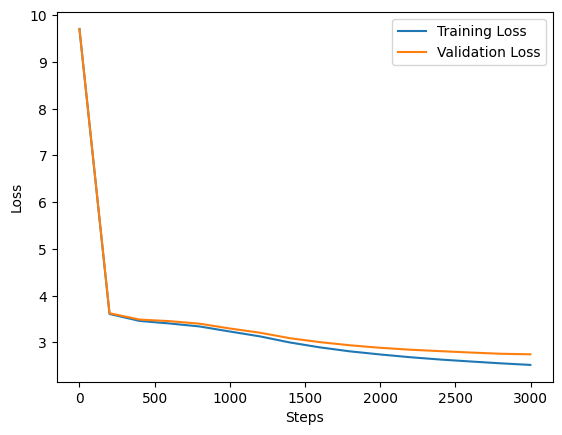

In [15]:
#train the model
#create the optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=cfg.get("learning_rate"))

#train
def training(m,w, max_iters, eval_interval, eval_iters, block_size, batch_size, device, train_set, validation_set ):

  best_loss = 100
  progress_bar = tqdm(range(max_iters)) # instanciation of the pogress bar
  train_losses = []  # List to store training losses
  val_losses = []  # List to store validation losses
  step_values = []  # List to store step values


  for step in range (max_iters):
    xb, yb = get_batch("train", block_size, batch_size , device, train_set, validation_set)

    #evaluate the loss
    if step % eval_interval == 0 or step==max_iters-1 :
      losses = estimate_loss(m, eval_iters, train_set, validation_set, block_size, batch_size, device)
      msg = ""
      if losses['eval'] < best_loss:
        best_loss = losses['eval']
        w.save_weights(m)
        msg = "Saving weights"
      print(f"step {step}/{max_iters}: train loss {losses['train']:.4f}, val loss {losses['eval']:.4f} ", msg)
      if monitoring : wandb.log({'train_loss': losses['train'], 'eval_loss': losses['eval'], 'step': step})

      # Append losses to the lists
      train_losses.append(losses['train'])
      val_losses.append(losses['eval'])
      step_values.append(step)


    logits, loss = m(xb, yb)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    progress_bar.update(1) #step by one the progress bar

  print("\n","End of training")

  # Plot the losses
  plt.plot(step_values, train_losses, label='Training Loss')
  plt.plot(step_values, val_losses, label='Validation Loss')
  plt.xlabel('Steps')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

training(m, w,  cfg.get('max_iters'), cfg.get('eval_interval'), cfg.get('eval_iters') , cfg.get('block_size'), cfg.get('batch_size'), cfg.get('device'), train_set, validation_set)



In [16]:
w.load_weights(m) #to load the state of the weight where the lost were the lower or if you have weights from a previous training
m.eval()

# generate with some context
def completion(context="\n", length=100):
  if word_level:
    context = tokenize_text(context)
  indices = [encode(context, stoi)]
  print(indices)
  idx = torch.tensor(indices, dtype=torch.long, device=cfg.get('device'))
  output = m.generate(idx, max_new_tok=100)
  return decode(m.generate(output, max_new_tok=length)[0].tolist(), itos)

with gr.Blocks() as demo:
    default_text = "\n"
    textbox = gr.Textbox(placeholder="Type here...", lines=4, value=default_text)
    btn = gr.Button("Autocomplete")
    slider = gr.Slider(label="length", minimum=100, maximum=4000)

    # define what will run when the button is clicked, here the textbox is used as both an input and an output
    btn.click(fn=completion, inputs= [textbox,  slider], outputs=textbox, queue=False)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ef3e28bddebf8e5c2.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
